In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import collections
import functools
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib as mpl

pgf_with_custom_preamble = {
    "text.usetex": False,    # use inline math for ticks
    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
}

def figsize(scale, height_ratio=1.0):
    fig_width_pt = 344.43306                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = height_ratio*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "sans-serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('dark', 40)

colors = sns.color_palette('dark', 40)

mpl.rcParams.update(pgf_with_latex)

# I make my own newfig and savefig functions
def newfig(width):
    plt.clf()
    fig = plt.figure(figsize=figsize(width))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename):
    plt.savefig('{}.pgf'.format(filename))
    plt.savefig('{}.pdf'.format(filename))

%matplotlib inline

# Kinetics

In [4]:
states_no_water = collections.defaultdict(dict)
nb_no_water = collections.defaultdict(dict)
t2name = {'t0': 'D', 't1': 'A', 't3': 'C', 't4': 'E', 't5': 'W'}
path = 'no_water/'
for f in os.listdir(path):
    if f.startswith('states_'):
        print(f)
        p = f.split('_')[3]
        code = f.split('_')[1]
        if code not in t2name:
            continue
        t = t2name[f.split('_')[1]]
        d = np.loadtxt(os.path.join(path, f))
        #d.dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]
        if t not in states_no_water[p]:
            states_no_water[p][t] = []
        states_no_water[p][t].append(d)
    elif f.startswith('nb_'):
        p = f.split('_')[6]
        t = f.split('_')[4]
        nb_no_water[p][t] = np.loadtxt(os.path.join(path, f))
        #nb_no_water[p][t].dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]

states_t2_p_0.001_564872_0.95_564872_traj_sim.csv
states_t4_p_0.001_450547_0.95_450547_traj_sim.csv
states_t3_p_0.001_290611_0.95_290611_traj_sim.csv
states_t2_p_0.001_290611_0.95_290611_traj_sim.csv
states_t1_p_0.001_450547_0.95_450547_traj_sim.csv
states_t1_p_0.001_290611_0.95_290611_traj_sim.csv
states_t4_p_0.001_564872_0.95_564872_traj_sim.csv
states_t0_p_0.001_450547_0.95_450547_traj_sim.csv
states_t0_p_0.001_564872_0.95_564872_traj_sim.csv
states_t0_p_0.001_290611_0.95_290611_traj_sim.csv
states_t3_p_0.001_450547_0.95_450547_traj_sim.csv
states_t3_p_0.001_564872_0.95_564872_traj_sim.csv
states_t4_p_0.001_290611_0.95_290611_traj_sim.csv
states_t1_p_0.001_564872_0.95_564872_traj_sim.csv
states_t2_p_0.001_450547_0.95_450547_traj_sim.csv


In [5]:
avg_states_no_water = collections.defaultdict(dict)
std_states_no_water = collections.defaultdict(dict)

max_states = {'A': 3, 'C': 3, 'E': 3, 'D': 3, 'B': 2}
column = {'D': 3, 'A': 2, 'C': 1, 'E': 2}

for p, p_ts in states_no_water.items():
    for t, l in p_ts.items():
        max_length = min([len(k) for k in l])
        max_first_nonzero = 0
        tmp_l = []
        for ll in l:
            dll = np.diff(ll[:, column[t]])
            first_nonzero = np.nonzero(dll)[0][0]
            if first_nonzero > max_first_nonzero:
                max_first_nonzero = first_nonzero
        for ll in l:
            tmp_l.append(ll[first_nonzero:max_length])
        av = np.average(tmp_l, axis=0)
        avg_states_no_water[p][t] = av
        std_states_no_water[p][t] = np.std(tmp_l, axis=0)

In [6]:
def f_1(y, t):
    s0 = y[0]
    s1 = y[1]
    s2 = y[2]
    k0 = 0.0001
    k1 = 0.0001
    k2 = 0.0001
    
    ds2dt = -k2*s2
    ds1dt = -k1*s1 + k2*s2
    ds0dt = k1*s1
    
    return np.array([ds0dt, ds1dt, ds2dt])

In [6]:
cr = '0.001'
tD = avg_states_no_water[cr]['D']
tA = avg_states_no_water[cr]['A']
tC = avg_states_no_water[cr]['C']
tE = avg_states_no_water[cr]['E']

def f_de(y, t, k):
    cD   = y[0]
    cEs1 = y[1]
    cEs0 = y[2]
    kcD   = k
    kcEs1 = k
    kcEs0 = k
    
    dcDdt = -kcD*cD
    dcEs1dt = kcD*cD - kcEs1*cEs1
    dcEs0dt = kcEs1*cEs1
    
    return np.array([dcDdt, dcEs1dt, dcEs0dt])

t0 = np.linspace(0, tE[:, 0][-1], 100)

y0 = np.array([1.0, 0.0, 0.0])
y = odeint(f_de, y0, t0, args=(float(cr),))

def f_ac(y, t, k):
    a = y[0]
    c = y[1]
    dadt = -k*a**2
    dcdt = k*a**2
    
    return np.array([dadt, dcdt])

t0 = np.linspace(0, tE[:, 0][-1], 50)
y_ac = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(1.4*float(cr),))
y_ac_raw = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(1.0*float(cr),))

51.0


/home/teodor/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


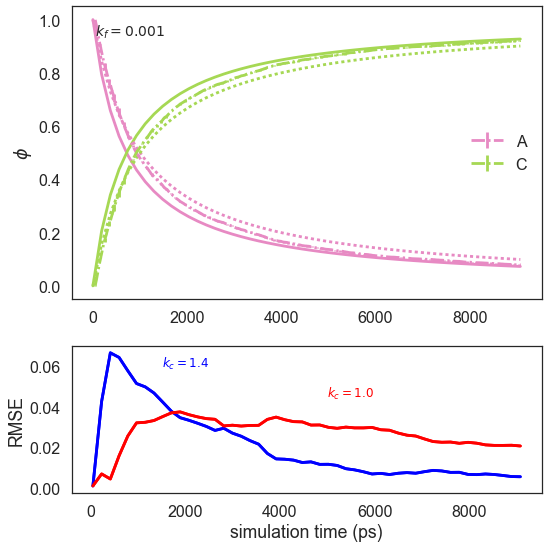

In [38]:
plt.rcParams['figure.figsize'] = (8, 8)
f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 1]})

a0.errorbar(tA[:, 0], tA[:, 2]/2000.0, std_states_no_water[cr]['A'][:, 2]/2000.0, errorevery=100, 
             linestyle='-.', label='A', color=sns.color_palette('Set2', 6)[3])
a0.errorbar(tC[:, 0], tC[:, 1]/2000.0, std_states_no_water[cr]['C'][:, 1]/2000.0, errorevery=100, 
             linestyle='-.', label='C', color=sns.color_palette('Set2', 6)[4])
a0.plot(t0, y_ac[:, 0], color=sns.color_palette('Set2', 6)[3])
a0.plot(t0, y_ac[:, 1], color=sns.color_palette('Set2', 6)[4])
a0.plot(t0, y_ac_raw[:, 0], color=sns.color_palette('Set2', 6)[3], linestyle=':')
a0.plot(t0, y_ac_raw[:, 1], color=sns.color_palette('Set2', 6)[4], linestyle=':')
a0.annotate(r'$k_f={}$'.format(cr), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=14)

a0.set_ylabel(r'$\phi$')
#a0.set_xlim([500, 7000])(0
a0.legend(loc=0)


fA = interp1d(tA[:, 0], tA[:, 2]/2000.0)
fC = interp1d(tC[:, 0], tC[:, 1]/2000.0)

t0 = np.linspace(tA[:, 0][0], tA[:, 0][-1], 50)
print(tA[:, 0][0])
a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac[:, 0], 2)), color='b')

t0 = np.linspace(tC[:, 0][0], tC[:, 0][-1], 50)
a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac[:, 1], 2)), color='b')

t0 = np.linspace(tA[:, 0][0], tA[:, 0][-1], 50)
a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac_raw[:, 0], 2)), color='r')

t0 = np.linspace(tC[:, 0][0], tC[:, 0][-1], 50)
a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac_raw[:, 1], 2)), color='r')

a1.annotate(r'$k_c=1.0$', xy=(5000, 0.045), fontsize=12, color='r')
a1.annotate(r'$k_c=1.4$', xy=(1500, 0.06), fontsize=12, color='b')

a1.legend(loc=0)
#a1.set_xlim([500, 7000])
a1.set_ylabel('RMSE')
a1.set_xlabel('simulation time (ps)')

f.tight_layout()

# PDI

In [7]:
cr = 0.001
scan_p0_1000_nowater = collections.defaultdict(list)
for f in sorted(os.listdir('../scan_p_1000/no_water/')):
    if f.startswith('polstat'):
        k = float(f.split('_')[2])
        if k != cr:
            continue
        d = np.loadtxt(os.path.join('../scan_p_1000/no_water/', f))
        header = open(os.path.join('../scan_p_1000/no_water/', f)).readline().replace('#', '').split()
        d.dtype = [(x, 'float') for x in header]
        scan_p0_1000_nowater[k].append(d)

In [8]:
no_water_polstat = []
for f in os.listdir('no_water/'):
    if f.startswith('polstat'):
        d = np.loadtxt(os.path.join('no_water', f))
        no_water_polstat.append(d)

In [9]:
from scipy import stats
from scipy.optimize import curve_fit

def pdi(p, a):
    return 1.0+a*p

(6, 925)
[ 1.2917257] [ 0.00249912]
[ 1.32228272] [ 0.00201823]


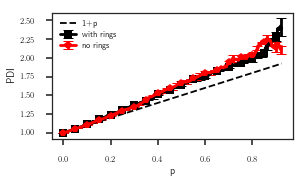

In [20]:
plt.rcParams['figure.figsize'] = figsize(0.9)
x_max = 2
for l in scan_p0_1000_nowater[cr]:
    x = (l['cr']/2000.0)[:, 0]
    if x[-1] == 0:
        continue
    x_max = min(x_max, x[-1])
x_new = np.arange(0, x_max, 0.001)
y_news = []
for l in scan_p0_1000_nowater[cr]:
    x = (l['cr']/2000.0)[:, 0]
    if (x[-1]) == 0:
        continue
    y = l['pdi'][:, 0]
    interpolation = interp1d(x, y)
    y_news.append(interpolation(x_new))
y_news = np.array(y_news)
print(y_news.shape)
y_avg, y_std = np.average(y_news, axis=0), np.std(y_news, axis=0)/np.sqrt(y_news.shape[0])
# for p in y_news:
#     plt.plot(x_new, p)
plt.errorbar(x_new, y_avg, y_std, linestyle='-', color='k', errorevery=20, capthick=1.0, capsize=5.0, 
             label='with rings', marker='s', markersize=8, markevery=50)
popt, pcov = curve_fit(pdi, x_new, y_avg)
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

noc_y_news = []
for d in no_water_polstat:
    x = (d[:, 0]/2000.0)
    y = d[:, 7]
    if x[-1] < x_new[-1]:
        continue
    interpolation = interp1d(x, y)
    noc_y_news.append(interpolation(x_new))
noc_y_news = np.array(noc_y_news)

noc_y_avg, noc_y_std = np.average(noc_y_news, axis=0), np.std(noc_y_news, axis=0)/np.sqrt(noc_y_news.shape[0])
plt.errorbar(x_new, noc_y_avg, noc_y_std, linestyle='-', color='r', errorevery=20, capthick=1.0, capsize=5.0, 
             label='no rings', marker='p', markersize=8, markevery=50)

popt, pcov = curve_fit(pdi, x_new, noc_y_avg)
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

plt.plot(x_new, 1+x_new, 'k--', linewidth=1.8, label='1+p')
plt.legend(loc=0)
plt.xlabel('p')
plt.ylabel('PDI')
plt.tight_layout()
plt.savefig('../result_graphics/pdi_no_cycles_with_cycles.pdf', dpi=200, tight_layout=True)

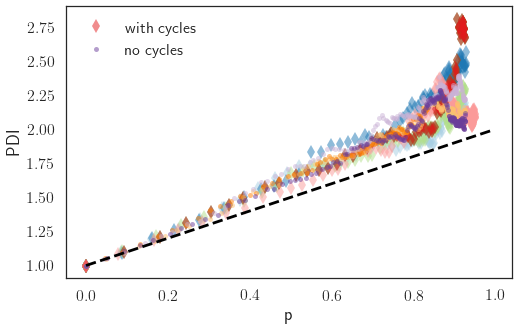

In [13]:
plt.rcParams['figure.figsize'] = (8, 8/1.6018)
for l in scan_p0_1000_nowater[cr]:
    x = (l['cr']/2000.0)
    y = l['pdi']
    c, = plt.plot(x, y, 'd', markevery=100, alpha=0.5, label='with cycles', markersize=10.0)
for d in no_water_polstat:
    nc, = plt.plot(d[:, 0]/2000.0, d[:, 7], label='no cycles', marker='.', alpha=0.5, markersize=10.0, linestyle='None', markevery=50)
plt.plot(np.arange(0.0, 1.0, 0.01), 1+np.arange(0.0, 1.0, 0.01), 'k--')
plt.ylabel('PDI')
plt.xlabel('p')
plt.legend((c, nc), ('with cycles', 'no cycles'), loc=0)
plt.savefig('pdi_no_cycles_with_cycles.pdf', dpi=200, tight_layout='tight')

In [26]:
plt.legend?